In [1]:
import numpy as np
import matplotlib.pyplot as plt
from monte_carlo import *

# Monte Carlo Integration (Ordinary MC)
Estimate multi-dimensional integral (over unit hypercube) by randomly sampling $N$ abscissas: 
$$ I = \int{d^dx \; f(x)} \approx  E = \frac{1}{N} \sum_{n=1}^{N}{f(x_n)} , $$
with equality for $N \rightarrow \infty $ (if the random process used to sample $x_n$ has a constant natural density). Define variance of a function $f$ as
$$ \sigma^2(f) = \int { d^dx \; (f(x)-I)^2 } .$$
Using this, the variance of the Monte Carlo estimate is
$$ 
\int { dx_1...dx_N \left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 }
= \int { dx_1...dx_N \frac{1}{N^2} \sum_{n=1}^N \sum_{m=1}^N (f(x_n)- I)(f(x_m)- I) } 
= \int {dx_1...dx_N \frac{1}{N^2} \sum_n{(f(x_n)-I)^2}}
= \frac{\sigma(f)^2}{N},
$$
since for $n \neq m$ the integrals separate and clearly $\int{dx\;(f(x)-I)} = 0$. 

The variance can be estimated using the unbiased sample variance
$$ S^2 = \frac{1}{N-1} \sum_{n=1}^N{(f(x_n)-E)^2} = \frac{1}{N-1}\sum_n{f(x_n)^2 } - \frac{N}{N-1}E^2$$

## Examples and introduction to visualizations
There are several methods for comparing the integration results from one or multiple Monte Carlo methods.
For a first example, note that the error aproximation from above (and the following Monte Carlo variants) relies on 
square-integrability of the integrand. If this is not given, the error estimate is not reliable and the estimates might not even
follow a Gaussian as predicted (in the limit) by the central limit theorem.

To exapnd on this, let us consider one square-integrable $\sin{(2 \pi x)}$ and one not square-integrable function $\sqrt{1/x}$. 

### Note on the implementation
Generally, n-dimensional functions are expected to take n numpy arrays (of equal lengths) as arguments.
If the function factorizes, this makes it very easy to implement:
```python
def fn(x, y, z):
    return x * y * z
```

However there might be cases in which it doesn't, in which case `np.vectorize` can be used:
```python
@np.vectorize
def fn(x, y):
    # granted, this is rediculous, but it serves as an example.
    if str(x).count('0') > 2:
        return 0
    else:
        return x + y
```

In [2]:
# periodic sin in 1 dimension
sin_1d = lambda x: np.sin(2*np.pi*x)
# periodic sin in any dimension; true integral value is 0
sin_nd = lambda *x: np.prod([sin_1d(xi) for xi in x], axis=0)

sqrtx_inv = lambda *x: np.sqrt(1/np.prod(x, axis=0))
sqrtx_inv_trueval = lambda dim: 2**dim  # true integral value depends on dimension

### Naive comparison of estimates
While not providing very statistically rigorous insights, a simple plot of the estimates with predicted error bars over 
a range of sample sizes (i.e. number of function iterations) can give an intuitive understanding of how the method behaves.

#### Number of iterations, sample size, number of function evaluations
When calling the plain Monte Carlo method, a number $N$ has to be given. This is the total sample size, i.e. the total number
of times the function is evaluated to estimate the integral. This is straight forward for the plain MC method, but later MC
variants have internal iterations (loops) with possibly varying number of sample sizes, and the term *number of iterations* becomes
ambiguous. The key parameter to compare the efficiency of different methods is the number of function evaluations.
To make this comparison easier, the various MC methods provide interfaces to fix internal parameters and then compute the integral
for a given number $N$ of function evaluations.

The following functions plot results over a range of function evaluations. Thus, the methods provided must only take two arguments,
the function and a number of function evaluations. For plain Monte Carlo this is just the object itself.

In [4]:
def plot_estimates(f, true_value, methods=[], Ns=range(100, 1100, 50)):
    """ Plot estimates of the integral over a range of sample sizes with predicted errorbars. 
    
    If method has attribute method_name use this as label.
    """
    if len(methods) == 0:
        raise ValueError("Need to provide at least one method.")
        
    Ns = np.array(Ns)
    count = len(Ns)
    
    estimates = np.empty(count)
    errors = np.empty(count)
    for m, method in zip(range(len(methods)), methods):
        for i, N in zip(range(count), Ns):
            sample = method(f, N)
            estimates[i], errors[i] = sample.integral, sample.integral_err
            
        name = method.method_name if hasattr(method, 'method_name') else "Method %d"%m
        plt.errorbar(Ns, estimates, yerr=errors, fmt='.', label=name)
    
    plt.plot([min(Ns), max(Ns)], [true_value, true_value], "-", label="true value")
    # configure plot
    plt.grid(True)
    plt.legend(loc='best')

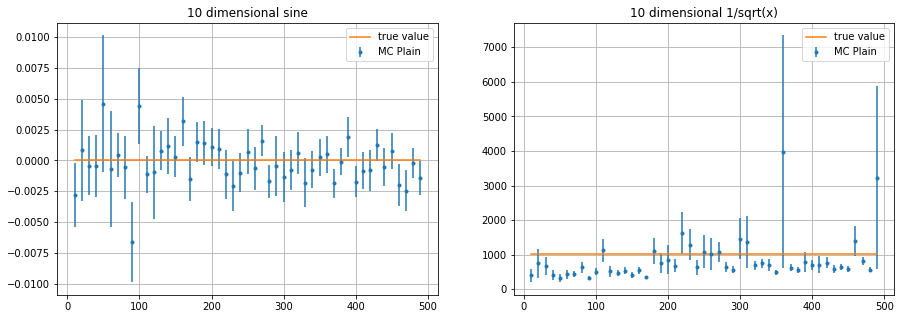

In [7]:
# Plot estimates for sine and 1/sqrt(x) in any dimension
dim = 10

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("%d dimensional sine"%dim)
plot_estimates(sin_nd, 0, Ns=range(10, 500, 10), methods=[PlainMC(dim)])

plt.subplot(122)
plt.title("%d dimensional 1/sqrt(x)"%dim)
plot_estimates(sqrtx_inv, sqrtx_inv_trueval(dim), Ns=range(10, 500, 10), methods=[PlainMC(dim)])
plt.show()

# Though qunatitatively, the 1/sqrt(x) integration can already be seen to behave oddly

### Behaviour of the error
While useful to check if the method works, the plot of estimates does not show quantitatively how the predicted error behaves,
especially in comparison to the actual deviation.

The following function plots the root mean squared of actual deviations over a given number of `iterations` for each given number of
function evaluations on a log-log scale. The MC methods are meant to (statistically) estimate this deviation (i.e. variance) 
by the returned error. In addition to the RMS devations, the (square root of) mean predicted variances are plotted.

If desired (`plot_fit=True`), the slope in the double-logarithic plot is fitted and displayed.

#### Expected behaviour
According to the analytical treatment at the beginning, the statistical error is expected to scale like $\sqrt{1/N}$. In the
double-logarithmic plot this corresponds to a line with slope $-1/2$. Values smaller than this (more negative) would imply faster
convergence.

In [5]:
def plot_rms(f, true_value, Ns=range(10, 1000, 100), iterations=1, methods=[], plot_fit=False):
    """ Plot RMS of deviations and RM of predicted variances. """
    if len(methods) == 0:
        raise ValueError("Need to provide at least one method.")
        
    Ns = np.array(Ns)
    # temporarily store the results of the methods in each iteration
    iteration_errors = np.empty(iterations)
    iteration_estimates = np.empty(iterations)
    
    for m, method in zip(range(len(methods)), methods):
        # store results for each sample size in Ns
        mean_vars = np.empty(len(Ns))
        rms = np.empty(len(Ns))
        
        for i, N in zip(range(len(Ns)), Ns):
            for j in range(iterations):
                sample = method(f, N)
                iteration_estimates[j], iteration_errors[j] = sample.integral, sample.integral_err
            # compute means
            mean_vars[i] = np.mean(iteration_errors**2)
            rms[i] = np.mean((iteration_estimates-true_value)**2)

        sqrt_mean_vars = np.sqrt(mean_vars)
        rms = np.sqrt(rms)
        
        if plot_fit:
            fit = np.polyfit(np.log(Ns), np.log(rms), 1)
            plt.loglog(Ns, np.exp(np.poly1d(fit)(np.log(Ns))), label="Fit, power %.2f"%fit[0])

        name = method.method_name if hasattr(method, 'method_name') else "Method %d"%i
        plt.loglog(Ns, sqrt_mean_vars, "o", label="predicted (%s)"%name, color="C%d"%m)
        plt.loglog(Ns, rms, "x", label="RMS deviations", color="C%d"%m)
        
    plt.xlabel("N")
    plt.legend(loc="best")
    plt.grid(True, which="both")

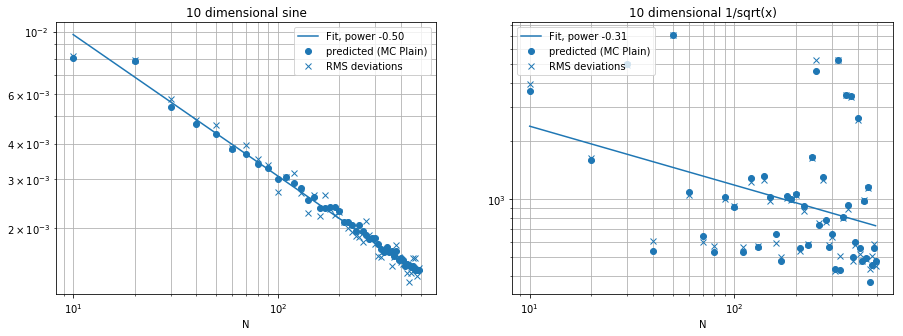

In [9]:
# Plot errors for sine and 1/sqrt(x) in any dimension
dim = 10
it = 100  # number of iterations over which to average

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("%d dimensional sine"%dim)
plot_rms(sin_nd, 0, Ns=range(10, 500, 10), iterations=it, methods=[PlainMC(dim)], plot_fit=True)

plt.subplot(122)
plt.title("%d dimensional 1/sqrt(x)"%dim)
plot_rms(sqrtx_inv, sqrtx_inv_trueval(dim), Ns=range(10, 500, 10), iterations=it, methods=[PlainMC(dim)], plot_fit=True)
plt.show()

## Estimate distribution
The estimates are predicted distribute according to a Gaussion with predicted standard deviation.
The following funtion plots the distribution of estimates of a method over a number of iterations.

In [6]:
def plot_distribution(fn, true_val, N, iterations, method, bins=20, name="", alpha=1):
    """ Plot the distribution of estimates and the predicted Gaussian.
    
    For the variance of the Gaussian, use the mean of variances obtained from the
    returned values of the method.
    
    Args:
        N: Number of function evaluatios to be passed to method.
        iterations: Number of estimates to compute with method, choose bins accordingly.
        bins: Number of bins for the histogram of computed estimates.
        alpha: Plot histogram with alpha value, useful if comparing multiple distributions.
        name: Use in label for the plot, useful if comparing multiple distributions.
    """
    values = np.empty(iterations)
    mean_var = 0
    
    for i in range(iterations):
        sample =  method(fn, N)
        values[i], var = sample.integral, sample.integral_err
        mean_var += var**2 / iterations
        
    plt.hist(values, bins=bins, normed=True, label="Actual " + name, alpha=alpha)
    
    x = np.linspace(true_val-4*np.sqrt(mean_var), true_val+4*np.sqrt(mean_var), 1000)
    plt.plot(x, np.exp(-(x-true_val)**2/2/mean_var) / np.sqrt(np.pi*2*mean_var), label="Predicted " + name)
    
    # config
    plt.grid(True)
    plt.legend(loc="best")

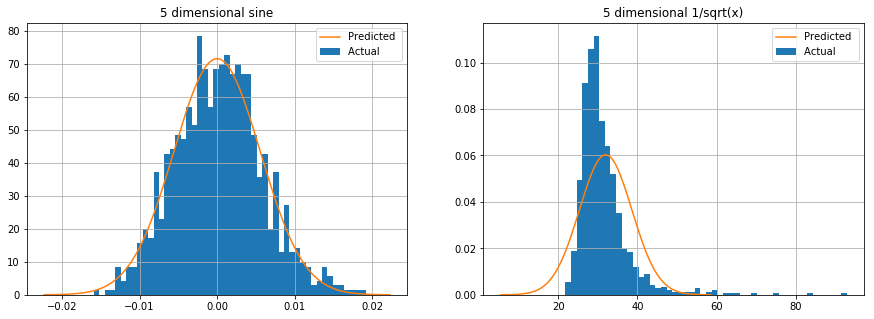

In [12]:
# Plot errors for sine and 1/sqrt(x) in any dimension
dim = 5
it = 1000  # number of iterations for the histogram
bins = 50  # number of bins for the histograms
N = 1000   # number of function evaluations

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("%d dimensional sine"%dim)
plot_distribution(sin_nd, 0, N=N, iterations=it, method=PlainMC(dim), bins=bins)

plt.subplot(122)
plt.title("%d dimensional 1/sqrt(x)"%dim)
plot_distribution(sqrtx_inv, sqrtx_inv_trueval(dim), N=N, iterations=it, method=PlainMC(dim), bins=bins)
plt.show()

## Variance Reducing Techniques
The error in the MC estimate scales like $1/\sqrt{N}$, which constitutes a slow convergence. Improving this value is desirable.
### Stratified sampling
Split $M=[0,1]^d$ into $k$ regions $M_j$, in each region perform MC with $N_j$ points. We obtain the estimate
$$ E = \sum_{j=1}^k {\frac{\text{vol}(M_j)}{N_j}} \sum_{n=1}^{N_j} {f(x_{jn})}, $$
and the variance of the MC estimate becomes
$$ 
\sum_{j=1}^k {\frac{\text{vol}(M_j)^2}{N_j} \left.\sigma^2(f)\right|_{M_j} }, \; \text{with} \;  
\left.\sigma^2(f)\right|_{M_j} = \frac{1}{\text{vol}(M_j)}\int_{M_j} {dx \left( f(x) - \frac{1}{\text{vol}(M_j)}\int_{M_j}{dx f(x)}  \right)^2}.
$$
Whether this method reduces or increases the variance depends on the choice of subspaces and respective point counts. It is obvious from the expression that to reduce the error/variance, regions with larger variance should have assigned larger $N_j$. Generally, for minimal variance the number of points must be chosen proportional to $\left.\sigma(f)\right|_{M_j}$.

### Volumes
At the core of stratified sampling (as well as the VEGAS algorithm) is a subdivision of the volume, with optionally
different weights / sample sizes in each region.

`GridVolumes` provides a simple grid-like (divisions of arbitrary size in each dimension) division of volumes.

In [13]:
# iterate and sample a 2D volume, divided into 4 regions (2 in each dim), with doulbe weight on the second region
volumes = GridVolumes(ndim=2, default_base_count=1, base_counts={(0,1):2}, divisions=2)

for N, sample, vol in volumes.iterate(1):
    print(N, vol)
    print(sample)

1 0.25
[[0.47896109 0.2593672 ]]
2 0.25
[[0.42368401 0.90086116]
 [0.44134231 0.52237329]]
1 0.25
[[0.66015451 0.19350734]]
1 0.25
[[0.70668691 0.54456676]]


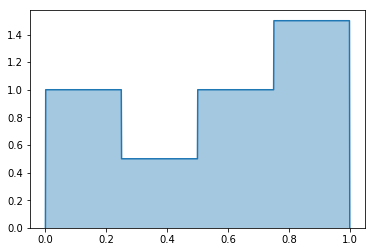

In [14]:
# Example: uniform grid with custom weights
vols = GridVolumes(divisions=4, ndim=1, default_base_count=2, base_counts={(1,): 1, (3,):3})
vols.plot_pdf()
xs = np.linspace(0, 1, 1000)
plt.plot(xs, vols.pdf(xs))

In [15]:
ind = vols.random_bins(3)
ind

array([[2, 1, 0]])

In [16]:
vols.pdf_indices(ind)

array([1. , 0.5, 1. ])

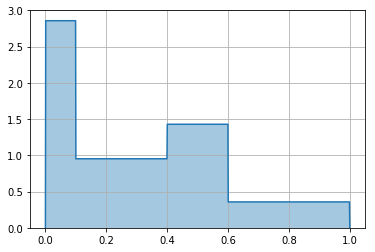

In [17]:
# Example: custom widths
vols = GridVolumes(bounds=([0,.1,.4,.6,1],), base_counts={(3,):1}, default_base_count=2)
vols.plot_pdf()
xs = np.linspace(0, 1, 1000)
plt.plot(xs, vols.pdf(xs))
plt.grid()

Note: Plotting the resulting probability distribution might be misleading for the stratified sampling method.
For stratified sampling each subregion is sampled independantly with deterministic sample sizes.

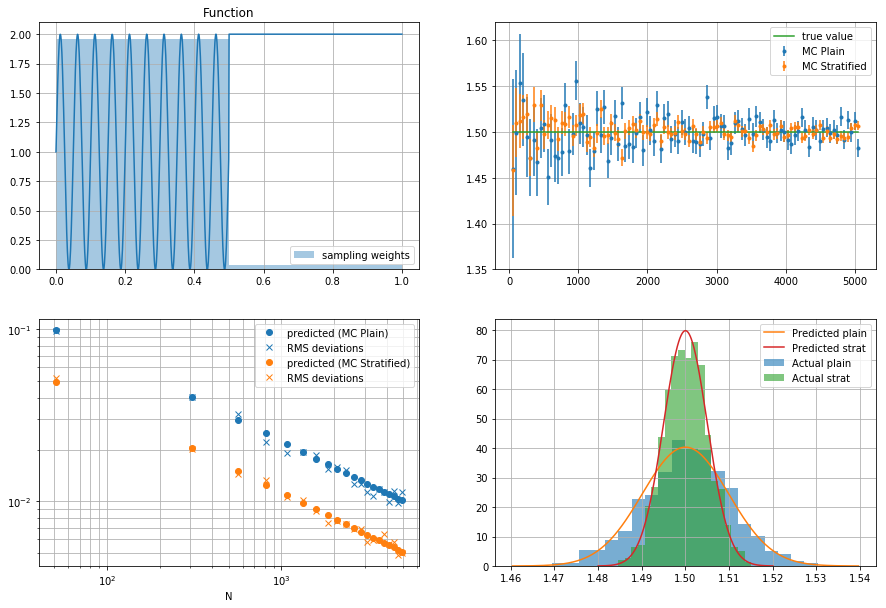

In [19]:
# As an example consider a function that oscillates rapidly in one half of the volume (interval).
# Stratified sampling is more efficient than plain MC if sampling more in this region.

half_sin = lambda x: (x<.5)*(1+np.sin(4*10*np.pi*x)) + (x>.5)*2
half_sin_integral = 1.5

volumes = GridVolumes(divisions=2, default_base_count=1, base_counts={(0,):50})
mc_strat = StratifiedMC(volumes)

plt.figure(figsize=(15,10))
plt.subplot(221)

# plot the function
plt.title("Function")
volumes.plot_pdf()
x = np.linspace(0,1,1000)
plt.plot(x,half_sin(x))
plt.grid()
plt.legend()

plt.subplot(222)
# compare to plain MC
plot_estimates(half_sin, half_sin_integral, Ns=range(volumes.total_base_count, volumes.total_base_count*100, volumes.total_base_count), 
               methods=[PlainMC(1), mc_strat.get_interface_infer_multiple()])

plt.subplot(223)
# compare errors
plot_rms(half_sin, half_sin_integral, Ns=range(volumes.total_base_count, volumes.total_base_count*100, volumes.total_base_count*5), iterations=100,
         methods=[PlainMC(1), mc_strat.get_interface_infer_multiple()])

plt.subplot(224)
# compare distributions
plot_distribution(half_sin, half_sin_integral, volumes.total_base_count*100, 1000, PlainMC(1), name="plain", alpha=.6)
plot_distribution(half_sin, half_sin_integral, volumes.total_base_count*100, 1000, mc_strat.get_interface_infer_multiple(), name="strat", alpha=.6)

plt.show()

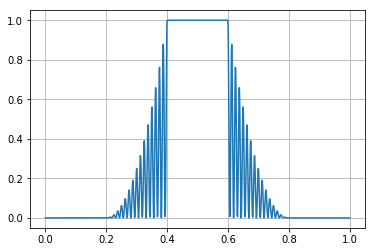

In [2]:
# A more complicated test function
tf_a = 16
tf_b = 1/.2**2
def osc(x):
    return x**2*np.cos(tf_a*np.pi*x/.2)**2*tf_b
def bound(a, x, b):
    return (x>a)*(x<=b)
def test_function(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
test_function_true_value = 2*.0333531 + .2

x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()
plt.show()

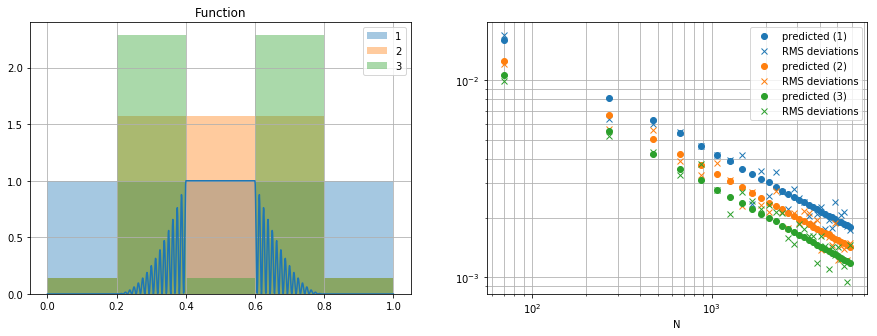

In [22]:
# Compare different weight choices: Areas with high variance vs high value.
# For stratified sampling it is best to prioratize areas with high variance (not value).
# This is substantially different from importance sampling.

# plot function and volume choices for stratified sampling
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

vol1 = GridVolumes(divisions=5, default_base_count=14)
vol2 = GridVolumes(divisions=5, default_base_count=2, base_counts={(1,):22, (3,):22, (2,):22})
vol3 = GridVolumes(divisions=5, default_base_count=2, base_counts={(1,):32, (3,):32})
vol1.plot_pdf("1")
vol2.plot_pdf("2")
vol3.plot_pdf("3")
plt.legend()

plt.subplot(122)
plot_rms(test_function, test_function_true_value, iterations=30, Ns=range(vol1.total_base_count, 6000, 200), 
         methods=[StratifiedMC(vol1, "1").get_interface_infer_multiple(), 
                  StratifiedMC(vol2, "2").get_interface_infer_multiple(), 
                  StratifiedMC(vol3, "3").get_interface_infer_multiple()])
plt.show()

**Observation**: It is most important to increase sampling in regions where f varies quickly.

(Note: stratified sampling is substantially different from importance sampling, which is why for stratified sampling regions of large variance of f should have bigger weights, whereas for importance sampling the pdf should be as close to f as possible.
In stratified sampling each region is considered individually and therefore when f is large but constant small samples will be acceptable. If $p(x)$ in importance sampling is small in these regions, these large values of f would be underrepresented and (as they yield large values of $f(x)/p(x)$) increase the variance of the MC estimate.)

### Importance sampling
Consider a change of variables
$$ \int {dx \; f(x)} = \int {\frac{f(x)}{p(x)} dx} = \int {\frac{f(x)}{p(x)} dP(x)} $$
with $$ p(x) = \frac{\partial^d}{\partial x_1 ... \partial x_d} P(x) .$$

Interpret $p(x)$ as a probability density with $p(x) \geq 0$ and normalized: $\int{dx\;p(x)} = 1$. If the $x_n$ are sampled from the corresponding distribution $P(x)$, we have
$$ E = \frac{1}{N} \sum_{n=1}^{N}{\frac{f(x_n)}{p(x_n)}}.$$
The variance of the MC estimate is (analogously to the first calculation)
$$ 
\int { dx_1...dx_N \; p(x_1)...p(x_N)\left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 } 
= \frac{1}{N} \int {dx \; p(x) \left( \frac{f(x)}{p(x)} - I \right)^2 } = \frac{\sigma^2(f/p)}{N} \;,
$$
which may in turn be estimated by the sample variance, using E instead of I:
$$ 
\sigma^2\left(\frac{f}{p}\right) \approx S^2\left(\frac{f}{p}\right) 
= \frac{1}{N} \sum_{n=1}^N {\left(\frac{f(x_n)}{p(x_n)}\right)^2} - E^2 .
$$

Using $p$ which are (close to) zero where $f$ is not zero is dangerous as the variance diverges while the sample variance does not (appropriate regions are less likely to be sampled for small $p$).

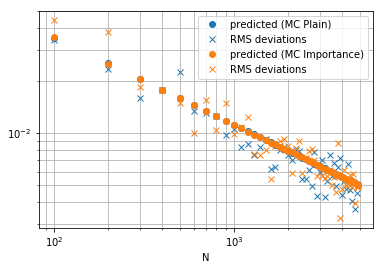

In [25]:
# with the default values (uniform distribution) monte carlo importance and plain monte carlo are exactly equivalent 
f = lambda x: np.sin(x*2*np.pi)**2
plot_rms(f, 1/2, Ns=range(100, 5000, 100), iterations=10, methods=[PlainMC(), ImportanceMC(densities.Uniform(1))])
plt.show()

## Generating Samples from a Given Distribution
### Acceptance-Rejection method
We want to sample according to a pdf $p(x)$. We know another (similar) pdf $h(x)$ s.t. $p(x) \leq Ch(x)$ for some $C \geq 0$.
Then use the following algorithm:
1. sample $x$ according to $h$
2. generate random number $u \in [0,1]$ and accept $x$ if $p(x) \geq uCh(x)$, else reject and start over

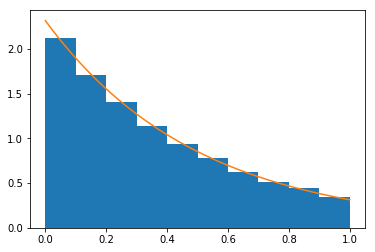

In [28]:
# 1D example
a = 2
p = lambda x:  np.exp(-a*x)  # want to sample according to this unnormalized pdf
norm = a/(1-np.exp(-a))      # multiply p by this to normalize
accept_reject = AcceptRejectSampler(p, 5)

plt.hist(accept_reject.sample(10000).data, bins=10, normed=True)
plt.plot(np.linspace(0,1,100), p(np.linspace(0,1,100))*norm)
plt.show()

### Metropolis algorithm
The metropolis algorithm is a simple Markov chain that, in it's limit, generates the desired distribution.
It starts from a state $\phi$ and transitions to a new state $\phi'$.

Generated 10000 samples.
Generated 20000 samples.
Generated 30000 samples.
Generated 40000 samples.
Generated 50000 samples.
Generated 60000 samples.
Generated 70000 samples.
Generated 80000 samples.
Generated 90000 samples.
Generated 100000 samples.


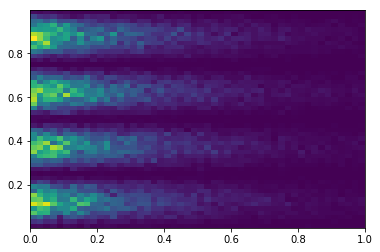

In [7]:
# test Metropolis
a =4
p = lambda x: np.exp(-a*x[0])*np.sin(4*np.pi*x[1])**2  # unnormalized
norm = a**2/(1-np.exp(-a))**2

metropolis =  DefaultMetropolis(2, p)  # defaults to uniform proposal
rand = metropolis.sample(100000, [.5, .5], log_every=10000).data.transpose()
plt.hist2d(rand[0], rand[1], bins=50, normed=True)
plt.show()

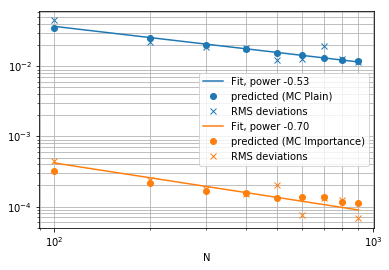

In [40]:
# Now apply distributions to importance sampling
dim = 1

sin2_nd = lambda *x: sin_nd(*x)**2
sin2_nd_trueval = lambda dim: .5**dim

p_ideal = lambda *x: sin2_nd(*[xi+.0005 for xi in x]) / sin2_nd_trueval(dim)   # almost ideal
accept_reject = AcceptRejectSampler(p_ideal, 1/sin2_nd_trueval(dim))  # max value of sin2_nd is 1
sampling = lambda count: accept_reject.sample(count).data

# create distribution
dist = make_dist_vect(dim, p_ideal, sampling)

plot_rms(sin2_nd, sin2_nd_trueval(dim), Ns=range(100, 1000, 100),  iterations=10, plot_fit=True,
         methods=[PlainMC(), ImportanceMC(dist)])

In [3]:
# create a few distributions to use

# compare importance sampling to the stratified boxing from before
vol = GridVolumes(divisions=5, default_base_count=2, base_counts={(1,):32, (3,):32})

p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/vol.total_base_count/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/vol.total_base_count/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptRejectSampler(p1, 3)
sampling2 = AcceptRejectSampler(p2, 2)
sampling3 = AcceptRejectSampler(p3, 3.5)

dist1 = make_dist(1, p1, lambda count: sampling1.sample(count).data)
dist2 = make_dist(1, p2, lambda count: sampling2.sample(count).data)
dist3 = make_dist(1, p3, lambda count: sampling3.sample(count).data)

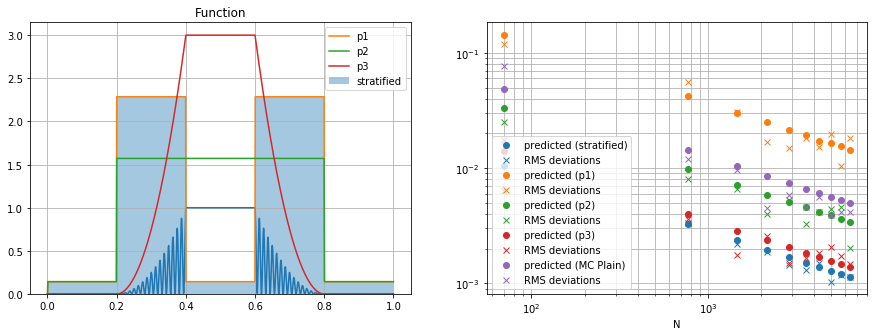

In [50]:
# use test_function and true_value from earlier
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

plt.plot(x,p1(x), label="p1")
plt.plot(x,p2(x), label="p2")
plt.plot(x,p3(x), label="p3")
vol.plot_pdf("stratified")
plt.legend()

plt.subplot(122)
plot_rms(test_function, test_function_true_value, iterations=10, Ns=range(vol.total_base_count, vol.total_base_count*100, vol.total_base_count*10), 
         methods=[StratifiedMC(volumes=vol, name="stratified").get_interface_infer_multiple(),
                  ImportanceMC(dist1, name="p1"),
                  ImportanceMC(dist2, name="p2"),
                  ImportanceMC(dist3, name="p3"),
                  PlainMC()])
plt.show()

## Adaptive Methods
### VEGAS Monte Carlo

Vegas Monte Carlo uses the same GridVolumes as the stratified sampling examples from before.
During the integration, the widths of the grid in each dimension are updated such that each division would contribute equally much. This leads to a denser grid around peaks of the integrand. The total pdf will approximate the integral as much as possible within the constraints.

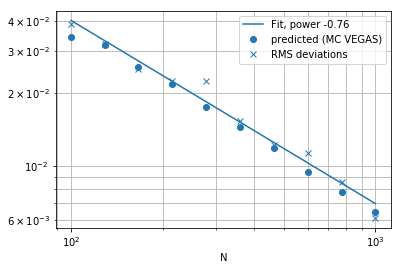

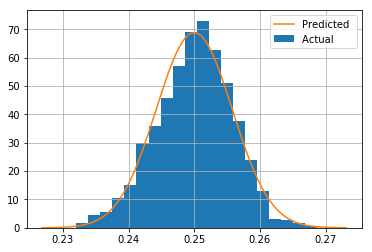

In [11]:
# Inspect how optimization impacts errors
trueval = .25
f = lambda x,y: np.sin(2 * np.pi * x)**2 * np.sin(2 * 2 * np.pi * y)**2

mc_vegas = VegasMC(divisions=30, c=20, ndim=2, var_weighted=False)

Ns = np.logspace(2, 3, 10, dtype=np.int)
# plot errors
plot_rms(f, trueval, Ns=Ns, iterations=70, methods=[mc_vegas.get_interface_infer_multiple(10)], plot_fit=True)
plt.show()

# plot distribution
plot_distribution(f, trueval, 1000, 1000, mc_vegas.get_interface_infer_multiple(100))
plt.show()

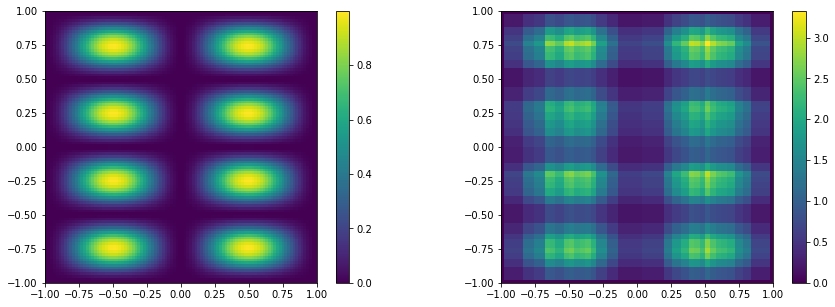

In [53]:
plt.figure(figsize=(15, 5))

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)

plt.subplot(121)
plt.imshow(f(*mgrid), extent=(-1, 1, -1, 1))
plt.colorbar()

plt.subplot(122)
plt.imshow(mc_vegas.volumes(*mgrid), extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

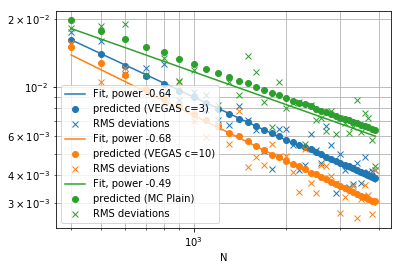

In [55]:
vegas3 = VegasMC(divisions=10, c=3, name="VEGAS c=3").get_interface_infer_multiple(100)
vegas5 = VegasMC(divisions=10, c=10, name="VEGAS c=10").get_interface_infer_multiple(100)
plot_rms(test_function, test_function_true_value, iterations=20, Ns=range(400, 4000, 100),
         methods=[vegas3, vegas5, PlainMC()], plot_fit=True)

0.2664676814407975  +-  0.000700468658894411


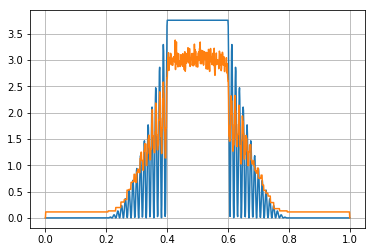

In [57]:
vegas = VegasMC(divisions=300, c=400)
sample = vegas(test_function, sub_eval_count=1000, iterations=50, chi=True)
est, err, chi2 = sample.integral, sample.integral_err, sample.chi2
print(est, ' +- ', err)

x = np.linspace(0,1,1000)
plt.plot(x, test_function(x) / est)
plt.plot(x, vegas.volumes.pdf(x))
plt.grid()
plt.show()

## Multi Channel Monte Carlo

Multi-channel Monte Carlo is an adaptive Monte Carlo integration technique based on importance sampling. 
Instead of one probability distribution, the multi-channel technique comprises a set of distributions $p_k$ (called channels) 
with respective weights $\alpha_k$. For each step, a channel is chosen randomly with probability $\alpha_k$, and $x_i$ is 
(pseudo-) randomly selected according to the chosen channel.

The integration process is split into iterations with $N_j$ function evaluations in each, such that after one iteration 
the channel weights can be updated to minimize the variance of $f/p$, where $p(x) = \sum_{k=1}^m \alpha_i p_k(x)$ is the 
overall or total probability distribution.

For each iteration, define
$$ W_{j, k}(\alpha) 
= \int_V \text{d} x \; p_j(x) \left(\frac{f(x)}{p(x)}\right)^2
\approx \frac{V}{N_j} \sum_{i=1}^{N_j} { \left( \frac{f(x_i)}{p(x_i} \right) } , \\
W_j(\alpha)
 = \int_V \text{d} x \; p(x) \left(\frac{f(x)}{p(x)}\right)^2
\approx \sum_{k=1}^m \alpha_k W_{j,k} $$

where the right sides are the Monte Carlo estimates. $W_{j,k}$ can be understood as the contribution of channel $j$ 
to the total variance of the integrand. To reduce the variance, channels that contribute disproportionately much should 
have a larger weight. The channels are update according to

$$\alpha_k^{new} = \frac{\alpha_k (W_{j,k}(\alpha))^\beta}{\sum_k {\alpha_k (W_{j,k}(\alpha))^\beta}}, $$

with $\beta$ ranging from $1/2$ to $1/4$.

Analogous to importance sampling the integration estimate for one iteration is

$$ E_j = \frac{V}{N_j} \sum_{i=1}^{N_j} { \frac{f(x_i)}{p(x_i)} }, \\
\sigma_{E_j}^2 = \frac{W_j(\alpha) - I^2}{N} . $$

Since the estimate is independent of the channel weights, the estimates from all iterations can be combined into a total estimate:
$$ E = \frac{1}{N} \sum_j {N_j E_j} ,  \\
\sigma_E^2 = \frac{\sum_j \frac{Nj}{N}W_j - I^2}{N} , $$
where $N = \sum_j {N_j}$.

Depending on the problem it might be useful to have an initial phase of weight optimization that does not contribute to the total estimate, or an additional final phase in which the weights are not updated.

In [17]:
# test channel sampling
channels = MultiChannel([make_dist_vect(3, lambda *x: np.ones_like(x[0]), lambda N: np.random.rand(N*3).reshape(N,3)),
                         make_dist_vect(3, lambda x, y, z: 2*(z<=.5)*(x<=.5)*(y<=.5), lambda N: np.random.rand(N*3).reshape(N,3)/2)])
sample = channels.sample(1000)
# example of computing the mean, answer should be .5 in upper row, .25 in lower
np.add.reduceat(sample.data, sample.channel_bounds)  / sample.count_per_channel[:, np.newaxis]

array([[0.51034761, 0.49186047, 0.49407471],
       [0.25714876, 0.25307979, 0.25243706]])

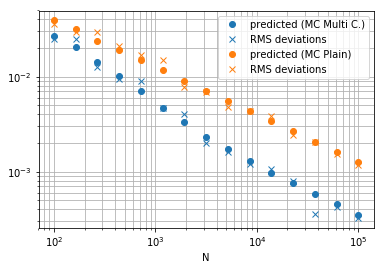

In [26]:
# use on test_function with the three probability distributions from before
channels = MultiChannel([dist1, dist2, dist3])

mcmci = MultiChannelMC(channels).get_interface_ratios(sub_eval_count=100, r1=0, r2=.5, r3=.5)

Ns = np.logspace(2, 5, 15, dtype=np.int)
plot_rms(test_function, test_function_true_value, Ns=Ns, iterations=20, 
               methods=[mcmci, PlainMC()])
plt.show()

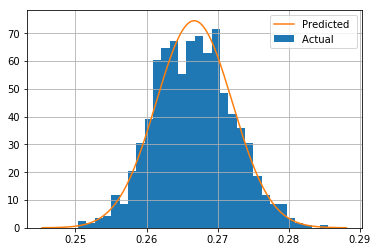

In [27]:
plot_distribution(test_function, test_function_true_value, 1e3, 1000, mcmci, bins=30)
plt.show()

0.004293575147370499 0.002667959259268825


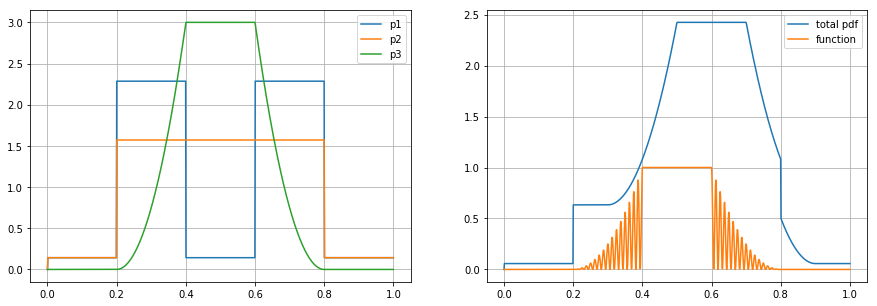

In [37]:
shift = .1
sampling3_shifted = AcceptRejectSampler(lambda x: p3(x-shift), 3.5).sample
dist3_shifted = make_dist(1, lambda x: p3(x-shift), lambda count: sampling3_shifted(count).data)
channels = MultiChannel([dist1, dist2, dist3_shifted])
mcmci = MultiChannelMC(channels).get_interface_ratios(sub_eval_count=100, r1=.2, r2=.4, r3=.4)

plt.figure(figsize=(15,5))
plt.subplot(121)
x = np.linspace(0,1,1000)
plt.plot(x, p1(x), label="p1")
plt.plot(x, p2(x), label="p2")
plt.plot(x, p3(x), label="p3")
plt.grid()
plt.legend()

plt.subplot(122)
sample = mcmci(test_function, 10000)
est, err = sample.integral, sample.integral_err

print(est-test_function_true_value, err)
channels.plot_pdf()
plt.plot(x, test_function(x), label="function")
plt.legend()
plt.grid()

plt.show()

# More on Sampling

### Importance Sampling
While in the above examples the`AcceptReject` class was used to sample according to a specific distribution for
Monte Carlo integration, in real applications distributions with a known inverse would be used, together with the inverse transfrom
method.

The following method (and Markov chain/Metropolis algorithms genrally) are used to construct samples according to more 
complicated distributions, when the sample creation is the main goal.

## Analyzing Markov Chains

In the following are some simple examples of Markov chains generated using Metropolis algorithms.

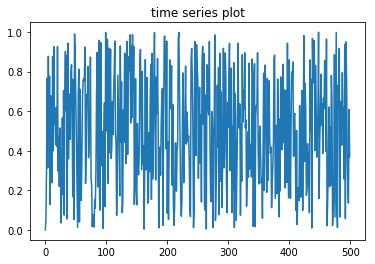

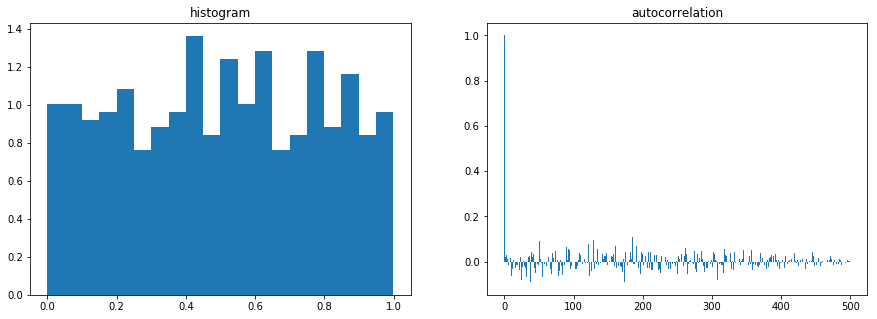

In [14]:
# example: uniform proposal and uniform pdf metropolis
metrop_uniform = DefaultMetropolis(1, lambda x: 1, proposal=lambda x: np.random.rand())
r = metrop_uniform.sample(500, 0)

plt.title("time series plot")
plt.plot(r.data)
plt.show()

plt.figure(figsize=(15, 5))

# plot histogram
plt.subplot(121)
plt.title("histogram")
_ = plt.hist(r.data, bins=20, normed=True)

# plot autocorrelation
plt.subplot(122)
plt.title("autocorrelation")
acov = util.auto_corr(r.data)
plt.bar(np.arange(len(acov)), acov)
plt.show()

Generated 5000 samples.
Generated 10000 samples.


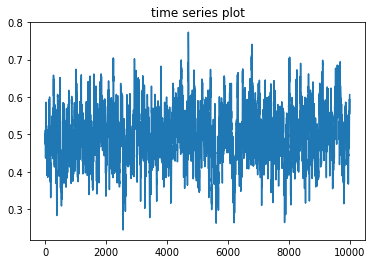

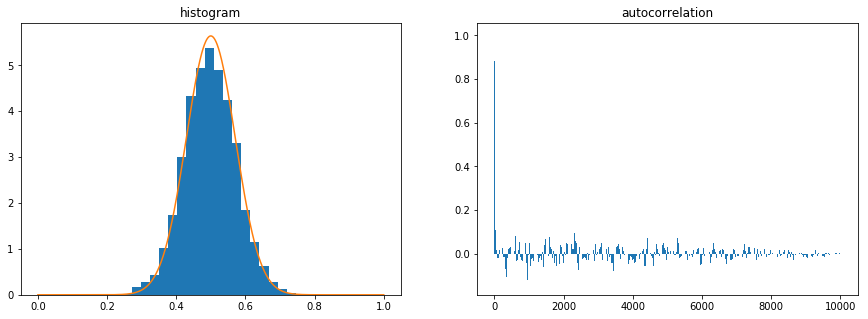

In [5]:
# example: local proposal and uniform pdf metropolis
delta = .1
proposal_generator = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
pdf = lambda x: np.exp(-(x-.5)**2/.01)
norm = 0.177245 # pdf / norm is normalized
metrop_gauss1 = DefaultMetropolis(1, pdf, proposal_pdf=proposal_pdf, proposal=proposal_generator)

r = metrop_gauss1.sample(10000, .5).data
plt.title("time series plot")
plt.plot(r)
plt.show()

plt.figure(figsize=(15, 5))

# plot histogram
plt.subplot(121)
plt.title("histogram")
_ = plt.hist(r, bins=20, normed=True)
x = np.linspace(0, 1, 1000)
plt.plot(x, pdf(x)/norm)

# plot autocorrelation
plt.subplot(122)
plt.title("autocorrelation")
acov = util.auto_corr(r)
plt.bar(np.arange(len(acov)), acov)
plt.show()

Generated 5000 samples.
Generated 10000 samples.


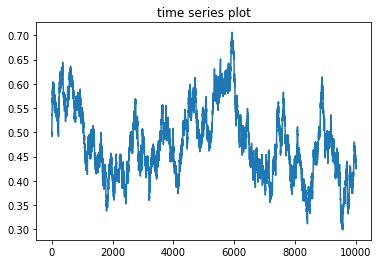

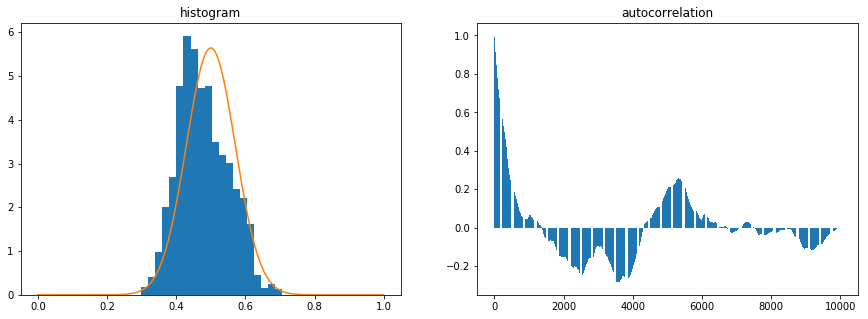

In [19]:
# example: local proposal and uniform pdf metropolis, proposal area 1/5th as large
delta = .02
proposal = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
metrop_gauss02 = DefaultMetropolis(1, pdf, proposal=proposal, proposal_pdf=proposal_pdf)

r = metrop_gauss02.sample(10000, .5).data[::1]
plt.title("time series plot")
plt.plot(r)
plt.show()

plt.figure(figsize=(15, 5))

# plot histogram
plt.subplot(121)
plt.title("histogram")
_ = plt.hist(r, bins=20, normed=True)
x = np.linspace(0, 1, 1000)
plt.plot(x, pdf(x)/norm)

# plot autocorrelation
plt.subplot(122)
plt.title("autocorrelation")
acov = util.auto_corr(r)
plt.bar(np.arange(len(acov)), acov)
plt.show()

Generated 10000 samples.
Generated 20000 samples.
Generated 30000 samples.
Generated 40000 samples.
Generated 50000 samples.
Generated 60000 samples.
Generated 70000 samples.
Generated 80000 samples.
Generated 90000 samples.
Generated 100000 samples.


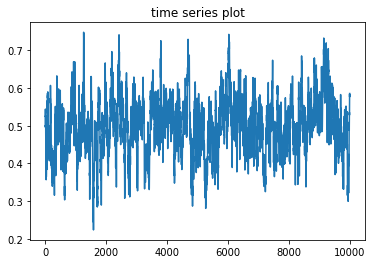

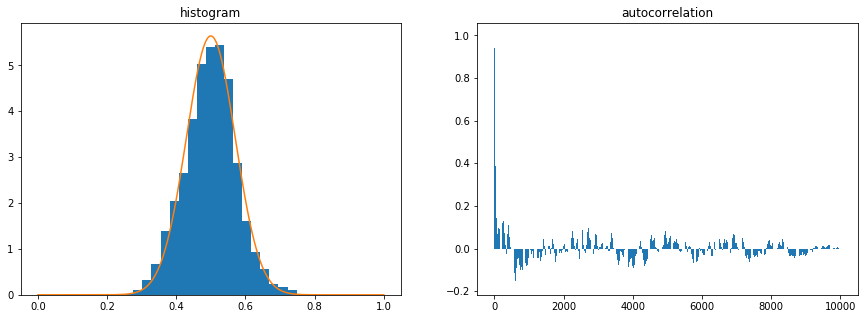

In [6]:
# example: local proposal and uniform pdf metropolis, proposal area 1/5th as large, now 10 times as many samples, subsample
delta = .02
proposal_generator = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
metrop_gauss02 = DefaultMetropolis(1, pdf, proposal_pdf=proposal_pdf, proposal=proposal_generator)

r = metrop_gauss02.sample(100000, .5, log_every=10000).data[::10]
plt.title("time series plot")
plt.plot(r)
plt.show()

plt.figure(figsize=(15, 5))

# plot histogram
plt.subplot(121)
plt.title("histogram")
_ = plt.hist(r, bins=20, normed=True)
x = np.linspace(0, 1, 1000)
plt.plot(x, pdf(x)/norm)

# plot autocorrelation
plt.subplot(122)
plt.title("autocorrelation")
acov = util.auto_corr(r)
plt.bar(np.arange(len(acov)), acov)
plt.show()

### Markov Chain Monte Carlo
Especially in statistics one might want to compute an integral such as
$$ \int f(x) p(x) \text{d}x, $$
where $p(x)$ is a probability distribution.
This can simply be done by using a Markov Chain to generate samples according to $p$. The main goal would the be to find a
Markov Chain algorithm (the appropriate update mechanism) with $p$ as equilibrium distribution.
The Markov Chain method is not further discussed here, but below is a simple implementation followed by an example.

See for example [here](http://mcmchandbook.net/) for an introduction to Markov Chain integration.

In [12]:
class MCMC(object):
    def __init__(self, batch_length, generator, initial):
        self.batch_length = batch_length
        self.generator = generator
        self.state = initial
        
    def sample_function(self, fn, batch_count):
        batch_means = np.empty(batch_count)
        for i in range(batch_count):
            xs = self.generator.sample(self.batch_length, self.state).data
            self.state = xs[-1]
            fn_values = fn(*xs.transpose())
            # CLT: batch_mean is distributed according to normal(actual mean, batch_vars/batch_length) 
            # (if MC is reversible, stationary)
            batch_means[i] = np.mean(fn_values)
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.title("batch means")
        plt.plot(batch_means, "o")
        plt.xlabel("N")
        plt.subplot(122)
        plt.title("ACF of batch means")
        acov = util.auto_corr(batch_means)
        plt.bar(np.arange(len(acov)), acov)
        plt.xlabel("N")
        plt.show()
        
        return batch_means
    
    def __call__(self, fn, N):
        assert N > self.batch_length, "N must be at least the size of a batch"
        batch_count = N // self.batch_length
        N = batch_count * self.batch_length
        
        batch_means = self.sample_function(fn, batch_count)
        mean = np.mean(batch_means)  # same as fn(chain) / N, since batch_count is constant throughout
        var_omc = np.mean((batch_means - mean)**2)  # estimates variance of fn / batch_length (i.e. variance of batch mean of fn)
        var_dependence = var_omc + 2 * np.mean(util.auto_cov(batch_means)[1:]) # this is probably not what we want
        
        # variance of the mean estimate is lag_cov(0) + 2 sum_k{ lag_cov(k) }
        # where lag_cov(k) is estimated by 1/m sum_i (batch_means_i - mean)(batch_means_{i+k} - mean)
        # ALTERNATIVELY: use smaller (thus better) convex minorant
        # this works because the sequence of batches is also a Markov chain and thus the CLT holds
        # i.e. here we estimate the mean batch value of fn, which (if the chain is stationary) is just the mean of fn
        return mean, np.sqrt(var_omc / batch_count), np.sqrt(var_dependence / batch_count)

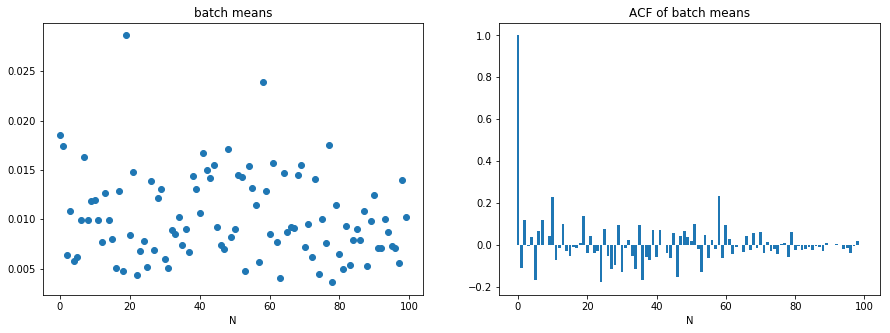

(0.010186193528228976, 0.00043368892693899897, 0.00043149301952815597)

In [13]:
delta = .05
proposal_generator = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
pdf = lambda x: np.exp(-(x-.5)**2/(2*0.1**2))
metrop_gauss05 = DefaultMetropolis(1, pdf, proposal_generator)

mcmc = MCMC(1000, metrop_gauss05, 0.5)
mcmc(lambda x: (x-.5)**2, 100000)

## MCMCMC

The mulit-channel Markov chain Monte Carlo ($\mathrm{MC^3}$) method combines 
multi-channel Monte Carlo integration with the Metropolis-Hasting algorithm to efficiently generate a sample according 
to the unnormalized distribution of a function $f$, which is expensive to evaluate. 


In the first phase, the function $f$ is integrated over the sample space using multi-channel Monte Carlo. 
The channels used for the integration are passed to the algorithm (and constructed using knowledge about the function such 
as sizes and locations of peaks, which physically correspond to resonances in the matrix element). As a result of the multi-channel
integration the channel weights are optimized, leading to a combined probability distribution $p_{IS}$ which approximates $f$. 
The total integral of $f$ may be of interest to users of the algorithm, but is unimportant for the sample generation.

The sampling, which follows the integration phase, generates a Markov Chain that mixes two Metropolis-Hasting update mechanisms. 
The first update mechanism is chosen with probability $\beta$, and is a Metropolis-Hasting update with candidates proposed 
according to the distribution $p_{IS}$ from the multi-channel integration (thus independently of the previous state in the chain). 
The second, chosen with probability $1-\beta$, is a Metropolis update that uses some local (and symmetric) proposal distribution 
$p_{loc}(x|y)$. The combined update mechanism is reversible and has the desired equilibrium distribution $f$.

Generated 5000 samples.
Generated 10000 samples.
Generated 15000 samples.
Generated 20000 samples.
Generated 25000 samples.
Generated 30000 samples.


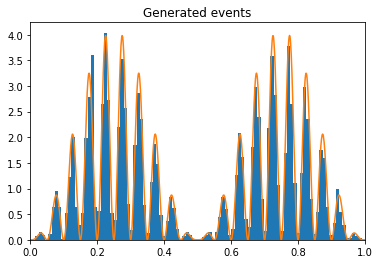

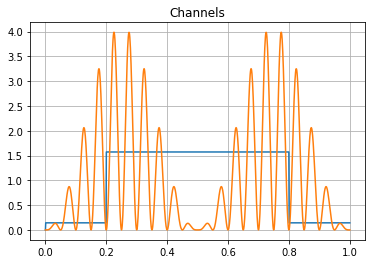

In [4]:
fn = lambda x: np.sin(2*np.pi*x)**2 * np.sin(10*2*np.pi*x)**2
channels = MultiChannel([dist2, dist3])
mc3_sampler = mc3.MC3Uniform(fn, channels, delta=.01, beta=1)
# beta = 1: only importance sampling
res = mc3_sampler(([], [500]*40, []), 30000).data

plt.title("Generated events")
plt.hist(res, normed=True, bins=100)
plt.xlim(0, 1)
x = np.linspace(0, 1, 1000)
plt.plot(x, fn(x)/mc3_sampler.integration_sample.integral)
plt.show()

plt.title("Channels")
mc3_sampler.channels.plot_pdf()
plt.plot(x, fn(x)/mc3_sampler.integration_sample.integral)
plt.grid()
plt.show()